## Getting yeast --> human orthologs

In [ ]:
import pandas as pd

In [ ]:
# Yeast String IDs is a list of all reviewed yeast proteins on UniProt
yeast_string_ids = pd.read_csv('yeast_string_ids.tsv', sep='\t')
yeast_string_ids

,From,To
0,D6VTK4,4932.YFL026W
1,O13297,4932.YPL228W
2,O13329,4932.YDR110W
3,O13516,4932.YPL081W
4,O13525,4932.YDR204W
...,...,...
6151,Q9ZZW3,4932.Q0143
6152,Q9ZZW4,4932.Q0142
6153,Q9ZZX7,4932.Q0032
6154,Q9ZZX8,4932.Q0017


In [ ]:
# Searching STRING Database for all proteins in Yeast String IDs that have a human homolog

import requests
import time

STRING_API_URL = "https://string-db.org/api/tsv/homology_best"
YEAST_TAXID = 4932  # Saccharomyces cerevisiae
HUMAN_TAXID = 9606  # Homo sapiens

yeast_string_ids_list = list(yeast_string_ids['To'])

yeast_to_human = {}

def batch_list(lst, size):
    for i in range(0, len(lst), size):
        yield lst[i:i + size]

for batch in batch_list(yeast_string_ids_list, 200):
    identifiers = "%0d".join(batch)
    params = {
        "identifiers": "%0d".join(batch),
        "species": YEAST_TAXID,
        "species_b": HUMAN_TAXID,
    }
    response = requests.get(STRING_API_URL, params=params)

    if response.status_code != 200:
        print(f"Batch failed! Skipping batch starting with {batch[0]}")
        continue

    data = response.text.strip().split("\n")

    if len(data) > 1:
        for line in data[1:]:
            fields = line.strip().split("\t")
            stringId_A = fields[1]
            stringId_B = fields[3]
            bitscore = fields[4]
            yeast_to_human[stringId_A] = (stringId_B, bitscore)
    else:
        print(f"No homologs found for batch starting with {batch[0]}")

with open("yeast_to_human_best_homolog.tsv", "w") as out_file:
    out_file.write("Yeast_STRING_ID\tHuman_STRING_ID\tBitScore\n")
    for yeast, (human, bitscore) in yeast_to_human.items():
        out_file.write(f"{yeast}\t{human}\t{bitscore}\n")

print(f"Done! Retrieved {len(yeast_to_human)} best homolog mappings.")



Done! Retrieved 3264 best homolog mappings.


In [ ]:
# Getting the top 1000 most confident homolog pairs

input_file = "yeast_to_human_best_homolog.tsv"
output_file = "top1000_homologs.tsv"
top_n = 1000

mappings = []

with open(input_file, "r") as f:
    next(f)
    for line in f:
        yeast_id, human_id, bitscore = line.strip().split("\t")
        mappings.append((yeast_id, human_id, float(bitscore)))

mappings.sort(key=lambda x: x[2], reverse=True)
top_mappings = mappings[:top_n]

with open(output_file, "w") as out:
    out.write("Yeast_STRING_ID\tHuman_STRING_ID\tBitScore\n")
    for yeast_id, human_id, bitscore in top_mappings:
        out.write(f"{yeast_id}\t{human_id}\t{bitscore}\n")


In [ ]:
best_homologs = pd.read_csv('top1000_homologs.tsv', sep='\t')
best_yeast_strings = list(best_homologs['Yeast_STRING_ID'])
best_human_strings = list(best_homologs['Human_STRING_ID'])
with open("best_yeast_strings_top1000.txt", "w") as f:
    f.write("\n".join(best_yeast_strings))
with open("/best_human_strings_top1000.txt", "w") as f:
    f.write("\n".join(best_human_strings))

## Retrieve FASTA sequences and GO terms from UniProt (Done Online)

## Generate ESM-C Embeddings (Done Online)

## Calculate Cosine Similarity and Euclidean Distance Between Embeddings

In [ ]:
import pickle
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
with open("final_human_esmc_embeddings.pkl", "rb") as f:
    human_embeddings = pickle.load(f)

with open("final_yeast_esmc_embeddings.pkl", "rb") as f:
    yeast_embeddings = pickle.load(f)

pooled_human = {k: torch.tensor(v).mean(dim=0) for k, v in human_embeddings.items()}
pooled_yeast = {k: torch.tensor(v).mean(dim=0) for k, v in yeast_embeddings.items()}


Top-5 for Q6P2Q9:
  P33334  |  similarity: 0.9949
  P13517  |  similarity: 0.9723
  P53886  |  similarity: 0.9657
  Q03280  |  similarity: 0.9641
  P38811  |  similarity: 0.9617

Top-5 for P27708:
  P32327  |  similarity: 0.9242
  P11154  |  similarity: 0.9212
  P41819  |  similarity: 0.9156
  P52489  |  similarity: 0.9124
  Q03195  |  similarity: 0.9116

Top-5 for Q9NU22:
  Q12019  |  similarity: 0.9427
  Q03280  |  similarity: 0.9388
  P53886  |  similarity: 0.9368
  Q08562  |  similarity: 0.9356
  P38110  |  similarity: 0.9341


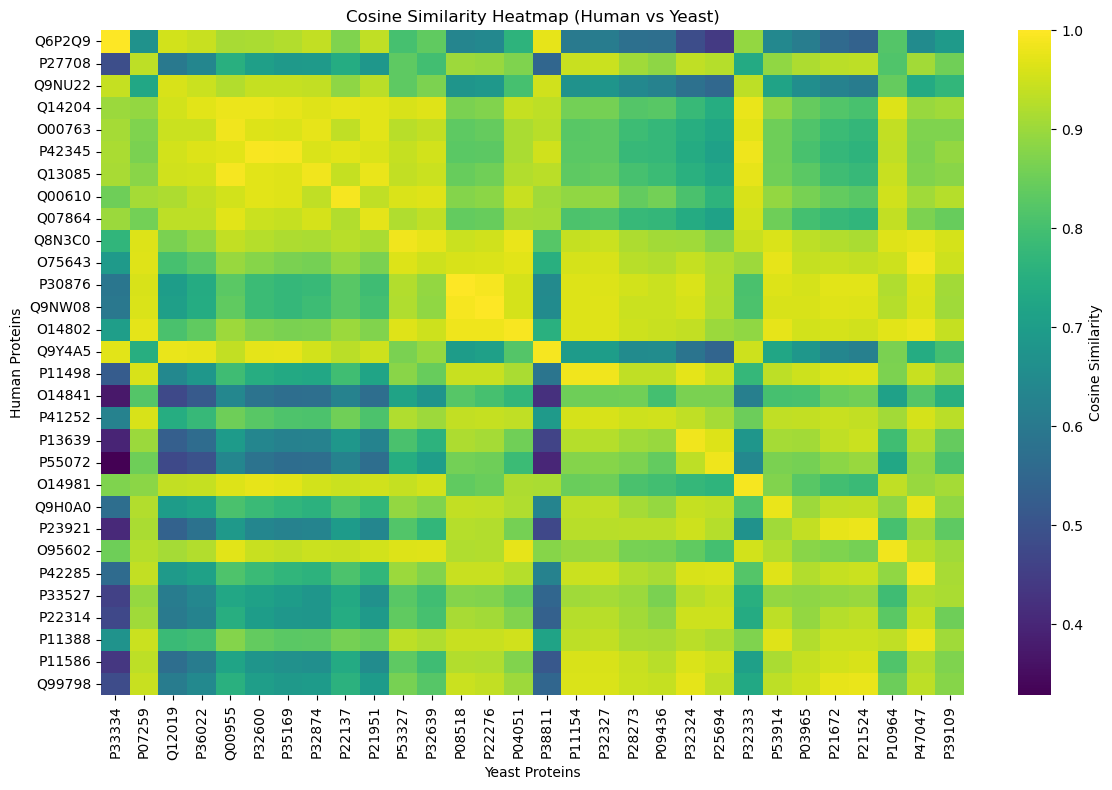

In [ ]:
human_keys = list(pooled_human.keys())
yeast_keys = list(pooled_yeast.keys())

human_matrix = np.stack([pooled_human[k] for k in human_keys])
yeast_matrix = np.stack([pooled_yeast[k] for k in yeast_keys])

cosine_sims = cosine_similarity(human_matrix, yeast_matrix)

k = 5

top_k_results_cosine = {}
for i, human_protein in enumerate(human_keys):
    sims = cosine_sims[i]
    top_k_indices = np.argsort(sims)[::-1][:k]
    top_k_hits = [(yeast_keys[j], sims[j]) for j in top_k_indices]
    top_k_results_cosine[human_protein] = top_k_hits

for query, hits in list(top_k_results_cosine.items())[:3]:  # show a few
    print(f"\nTop-{k} for {query}:")
    for hit, score in hits:
        print(f"  {hit}  |  similarity: {score:.4f}")

normalized_sims = (cosine_sims - cosine_sims.min()) / (cosine_sims.max() - cosine_sims.min())
plt.figure(figsize=(12, 8))
sns.heatmap(
    normalized_sims[:30, :30],
    xticklabels=yeast_keys[:30],
    yticklabels=human_keys[:30],
    cmap="viridis",
    cbar_kws={'label': 'Cosine Similarity'}
)
plt.title("Cosine Similarity Heatmap (Human vs Yeast)")
plt.xlabel("Yeast Proteins")
plt.ylabel("Human Proteins")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


Top-5 closest yeast proteins to Q6P2Q9 (Euclidean):
1. P33334 (score: -0.1361)
2. P13517 (score: -0.3080)
3. P53886 (score: -0.3618)
4. Q03280 (score: -0.3784)
5. P38811 (score: -0.3804)

Top-5 closest yeast proteins to P27708 (Euclidean):
1. P32327 (score: -0.2832)
2. P11154 (score: -0.2910)
3. P52489 (score: -0.2965)
4. P07244 (score: -0.3040)
5. P41819 (score: -0.3054)

Top-5 closest yeast proteins to Q9NU22 (Euclidean):
1. Q12019 (score: -0.3383)
2. Q08562 (score: -0.3539)
3. P33202 (score: -0.3631)
4. Q00416 (score: -0.3650)
5. Q03897 (score: -0.3693)

Top-5 closest yeast proteins to Q14204 (Euclidean):
1. Q06706 (score: -0.2109)
2. Q00955 (score: -0.2290)
3. P32600 (score: -0.2301)
4. P53258 (score: -0.2336)
5. P32492 (score: -0.2364)

Top-5 closest yeast proteins to O00763 (Euclidean):
1. Q00955 (score: -0.1812)
2. P32874 (score: -0.2374)
3. P32333 (score: -0.2534)
4. P32562 (score: -0.2653)
5. P32863 (score: -0.2690)


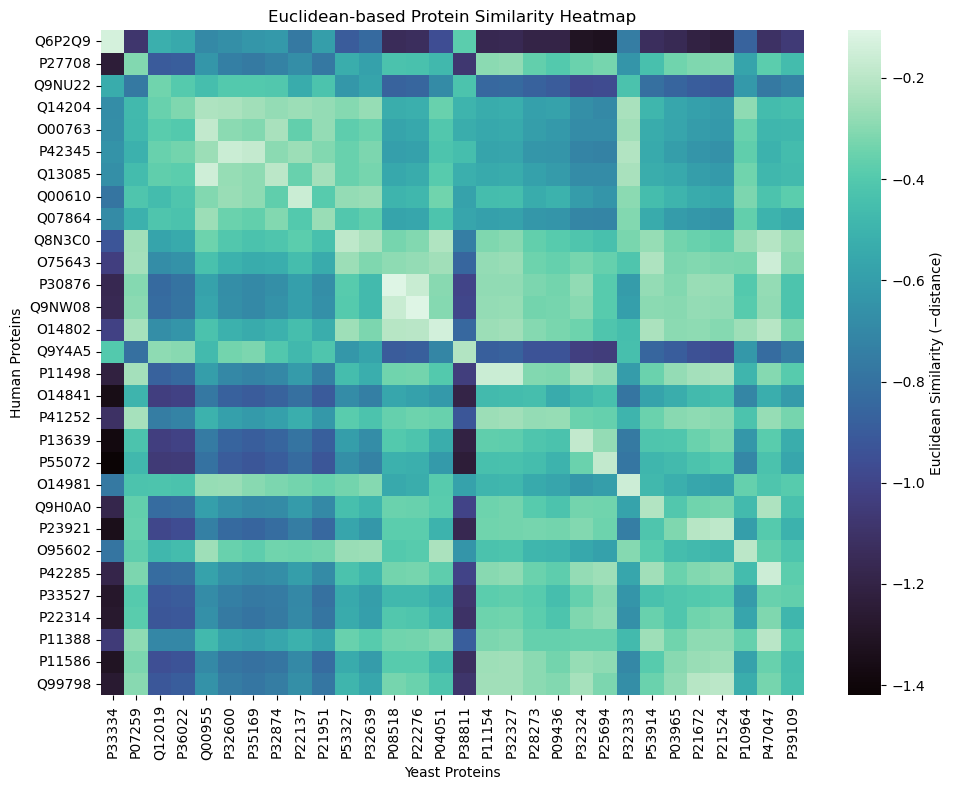

In [ ]:
human_ids = list(pooled_human.keys())
yeast_ids = list(pooled_yeast.keys())

human_matrix = torch.stack([pooled_human[k] for k in human_ids]).numpy()
yeast_matrix = torch.stack([pooled_yeast[k] for k in yeast_ids]).numpy()

euclidean_dists = euclidean_distances(human_matrix, yeast_matrix)
euclidean_sims = -euclidean_dists

def top_k_neighbors(similarity_matrix, k):
    topk_indices = np.argsort(-similarity_matrix, axis=1)[:, :k]
    topk_scores = np.take_along_axis(similarity_matrix, topk_indices, axis=1)
    return topk_indices, topk_scores

k = 5
topk_indices_euc, topk_scores_euc = top_k_neighbors(euclidean_sims, k)

for idx in range(5):
    print(f"\nTop-{k} closest yeast proteins to {human_ids[idx]} (Euclidean):")
    for i in range(k):
        print(f"{i+1}. {yeast_ids[topk_indices_euc[idx][i]]} (score: {topk_scores_euc[idx][i]:.4f})")

plt.figure(figsize=(10, 8))
sns.heatmap(euclidean_sims[:30, :30], xticklabels=yeast_ids[:30], yticklabels=human_ids[:30], cmap="mako", cbar_kws={"label": "Euclidean Similarity (−distance)"})
plt.title("Euclidean-based Protein Similarity Heatmap")
plt.xlabel("Yeast Proteins")
plt.ylabel("Human Proteins")
plt.tight_layout()
plt.show()

In [ ]:
rows = []
for human_idx, similarities in enumerate(cosine_sims):
    top_k_indices = similarities.argsort()[::-1][:20]  # top-k, descending
    for rank, yeast_idx in enumerate(top_k_indices, start=1):
        rows.append({
            "human_protein": human_keys[human_idx],
            "rank": rank,
            "yeast_protein": yeast_keys[yeast_idx],
            "similarity_score": similarities[yeast_idx]
        })

df = pd.DataFrame(rows)
df.to_csv("topk_human_yeast_matches_cosine_FINAL.csv", index=False)

rows = []
for human_idx, similarities in enumerate(euclidean_sims):
    top_k_indices = similarities.argsort()[::-1][:20]  # top-k, descending
    for rank, yeast_idx in enumerate(top_k_indices, start=1):
        rows.append({
            "human_protein": human_keys[human_idx],
            "rank": rank,
            "yeast_protein": yeast_keys[yeast_idx],
            "similarity_score": similarities[yeast_idx]
        })

df = pd.DataFrame(rows)
df.to_csv("topk_human_yeast_matches_euclidean_FINAL.csv", index=False)

## Calculate Jaccard Similarity Between PLM Embedding-Based GO Predictions and Truth

In [ ]:
human_go = pd.read_csv('best_human_go_top1000.tsv', sep='\t')
human_go = human_go[['Entry', 'Gene Ontology (GO)', 'Gene Ontology IDs']]
human_go = human_go.dropna()

yeast_go = pd.read_csv('best_yeast_go_top1000.tsv', sep='\t')
yeast_go = yeast_go[['Entry', 'Gene Ontology (GO)', 'Gene Ontology IDs']]
yeast_go = yeast_go.dropna()

In [ ]:
yeast_go = yeast_go.rename(columns={"Entry": "yeast_protein"})
matches_df = pd.read_csv("topk_human_yeast_matches_cosine_FINAL.csv")
merged_df = pd.merge(matches_df, yeast_go, on="yeast_protein", how="left")
merged_df

,human_protein,rank,yeast_protein,similarity_score,Gene Ontology (GO),Gene Ontology IDs
0,Q6P2Q9,1,P33334,0.994874,catalytic step 2 spliceosome [GO:0071013]; cyt...,GO:0000244; GO:0000350; GO:0000387; GO:0000389...
1,Q6P2Q9,2,P13517,0.972315,actin cortical patch [GO:0030479]; actin cytos...,GO:0000131; GO:0000142; GO:0000902; GO:0005886...
2,Q6P2Q9,3,P53886,0.965683,anaphase-promoting complex [GO:0005680]; cytop...,GO:0000922; GO:0005634; GO:0005680; GO:0005737...
3,Q6P2Q9,4,Q03280,0.964077,cytoplasm [GO:0005737]; nucleolus [GO:0005730]...,GO:0000278; GO:0000447; GO:0000448; GO:0000472...
4,Q6P2Q9,5,P38811,0.961714,NuA4 histone acetyltransferase complex [GO:003...,GO:0000124; GO:0005634; GO:0006281; GO:0006351...
...,...,...,...,...,...,...
16935,Q9HAU5,16,P38086,0.942337,nucleus [GO:0005634]; ATP binding [GO:0005524]...,GO:0000724; GO:0003690; GO:0005524; GO:0005634...
16936,Q9HAU5,17,Q06708,0.941304,endosome membrane [GO:0010008]; fungal-type va...,GO:0000329; GO:0006661; GO:0010008; GO:0010511...
16937,Q9HAU5,18,P41810,0.940812,COPI vesicle coat [GO:0030126]; Golgi membrane...,GO:0000139; GO:0005198; GO:0006886; GO:0006888...
16938,Q9HAU5,19,P32657,0.940429,chromatin [GO:0000785]; mitochondrion [GO:0005...,GO:0000124; GO:0000182; GO:0000724; GO:0000729...


In [ ]:
predicted_go = {}

for human_id, group in merged_df.groupby("human_protein"):
    go_scores = defaultdict(float)

    for _, row in group.iterrows():
        if pd.isna(row["Gene Ontology IDs"]):
            continue
        go_ids = row["Gene Ontology IDs"].split(";")
        sim = row["similarity_score"]

        for go_id in go_ids:
            go_scores[go_id.strip()] += sim

    ranked_gos = sorted(go_scores.items(), key=lambda x: x[1], reverse=True)

    top_go_terms = [go for go, score in ranked_gos[:10]]
    predicted_go[human_id] = top_go_terms

predicted_go_df = pd.DataFrame([
    {"human_protein": hp, "predicted_GO_IDs": ";".join(gos)}
    for hp, gos in predicted_go.items()
])

truth_go_dict = {
    row["Entry"]: set(str(row["Gene Ontology IDs"]).split(";"))
    for _, row in human_go.iterrows()
    if not pd.isna(row["Gene Ontology IDs"])
}

predicted_go_dict = {
    row["human_protein"]: set(str(row["predicted_GO_IDs"]).split(";"))
    for _, row in predicted_go_df.iterrows()
}

jaccard_scores = []

for human_id in predicted_go_dict:
    predicted = predicted_go_dict.get(human_id, set())
    predicted = set(go.strip() for go in predicted)
    truth = truth_go_dict.get(human_id, set())
    truth = set(go.strip() for go in truth)

    if not predicted or not truth:
        jaccard = None
    else:
        jaccard = len(predicted & truth) / len(predicted | truth)

    jaccard_scores.append({
        "human_protein": human_id,
        "jaccard_similarity": jaccard
    })

plm_jaccard_df = pd.DataFrame(jaccard_scores)
plm_jaccard_df.to_csv('plm_jaccard_FINAL.csv')
plm_jaccard_df

,human_protein,jaccard_similarity
0,A2PYH4,0.538462
1,A2RTX5,0.333333
2,A5YKK6,0.027778
3,O00160,0.150000
4,O00203,0.019231
...,...,...
842,Q9Y6D5,0.054054
843,Q9Y6E0,0.056604
844,Q9Y6M4,0.166667
845,Q9Y6M5,0.093023


## BLAST Baseline

In [ ]:
!makeblastdb -in best_yeast_fasta_top1000.fasta -dbtype prot -out final_yeast_BLAST_db/yeast



Building a new DB, current time: 04/26/2025 21:47:23
New DB name:   /Users/yashasappaji/Desktop/spring_2025/cx4803-mlb/project/final_yeast_BLAST_db/yeast
New DB title:  /Users/yashasappaji/Desktop/spring_2025/cx4803-mlb/project/yeast_files/best_yeast_fasta_top1000.fasta
Sequence type: Protein
Keep MBits: T
Maximum file size: 3000000000B
Adding sequences from FASTA; added 1000 sequences in 0.019536 seconds.




In [ ]:
!blastp -query best_human_top1000.fasta -db final_yeast_BLAST_db/yeast -out final_yeast_blast_baseline_results.tsv \
  -outfmt '6 qseqid sseqid pident length bitscore evalue' -evalue 1e-5

In [ ]:
import pandas as pd
from collections import defaultdict

cols = ["qseqid", "sseqid", "pident", "length", "bitscore", "evalue"]
df = pd.read_csv("final_yeast_blast_baseline_results.tsv", sep="\t", names=cols)

df["qseqid"] = df["qseqid"].apply(lambda x: x.split("|")[1] if "|" in x else x)
df["sseqid"] = df["sseqid"].apply(lambda x: x.split("|")[1] if "|" in x else x)

df_sorted = df.sort_values(by=["qseqid", "bitscore"], ascending=[True, False])

k = 5
topk_blast = defaultdict(list)

for _, row in df_sorted.iterrows():
    qid = row["qseqid"]
    if len(topk_blast[qid]) < k:
        topk_blast[qid].append((row["sseqid"], row["bitscore"]))


In [ ]:
human_go = pd.read_csv('best_human_go_top1000.tsv', sep='\t')
human_go = human_go[['Entry', 'Gene Ontology (GO)', 'Gene Ontology IDs']]
human_go = human_go.dropna()

go_truth = {}
for index, row in human_go.iterrows():
    go_truth[row['Entry']] = row['Gene Ontology IDs'].split(';')

yeast_go = pd.read_csv('best_yeast_go_top1000.tsv', sep='\t')
yeast_go = yeast_go[['Entry', 'Gene Ontology (GO)', 'Gene Ontology IDs']]
yeast_go = yeast_go.dropna()

go_annotations = {}
for index, row in yeast_go.iterrows():
    go_annotations[row['Entry']] = row['Gene Ontology IDs'].split(';')

In [ ]:
go_predictions = {}

for human_protein, hits in topk_blast.items():
    go_scores = defaultdict(float)

    for yeast_protein, score in hits:
        yeast_go_terms = go_annotations.get(yeast_protein, set())
        for go_term in yeast_go_terms:
            go_scores[go_term.strip()] += score

    predicted_terms = {go for go, agg_score in go_scores.items()}
    go_predictions[human_protein] = predicted_terms

jaccard_scores = {}

for protein, predicted_terms in go_predictions.items():
    true_terms = go_truth.get(protein, set())
    true_terms = {term.strip() for term in true_terms}

    intersection = predicted_terms & true_terms
    union = predicted_terms | true_terms

    jaccard = len(intersection) / len(union) if union else 0.0
    jaccard_scores[protein] = jaccard

blast_jaccard = pd.DataFrame.from_dict(jaccard_scores, orient='index', columns=['jaccard_similarity']).reset_index().rename(columns={'index': 'human_protein'})
blast_jaccard

,human_protein,jaccard_similarity
0,A2PYH4,0.285714
1,A2RTX5,0.555556
2,A5YKK6,0.194444
3,O00160,0.125000
4,O00203,0.080645
...,...,...
842,Q9Y6D5,0.155556
843,Q9Y6E0,0.318182
844,Q9Y6M4,0.358025
845,Q9Y6M5,0.073171


Mean Jaccard similarity (BLAST): 0.2752


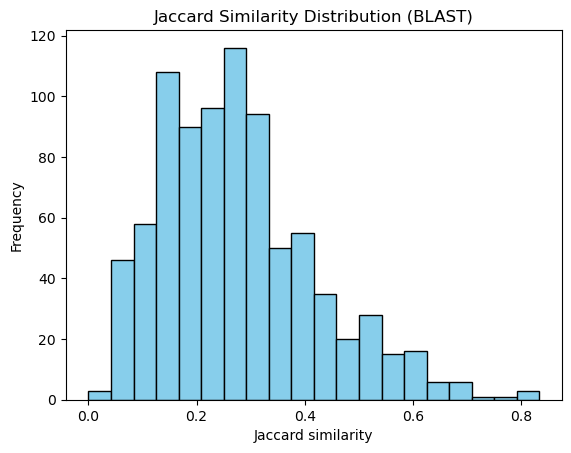

In [ ]:
jaccard_values = list(jaccard_scores.values())

mean_jaccard = np.mean(jaccard_values)
print(f"Mean Jaccard similarity (BLAST): {mean_jaccard:.4f}")

plt.hist(jaccard_values, bins=20, color='skyblue', edgecolor='black')
plt.title("Jaccard Similarity Distribution (BLAST)")
plt.xlabel("Jaccard similarity")
plt.ylabel("Frequency")
plt.show()

Mean Jaccard similarity (PLM Embeddings): 0.1358


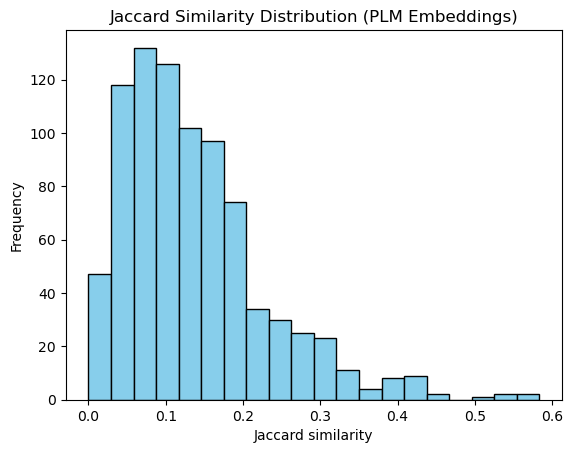

In [ ]:
plm_jaccard_values = list(plm_jaccard_df['jaccard_similarity'])

mean_jaccard = np.mean(plm_jaccard_values)
print(f"Mean Jaccard similarity (PLM Embeddings): {mean_jaccard:.4f}")

plt.hist(plm_jaccard_values, bins=20, color='skyblue', edgecolor='black')
plt.title("Jaccard Similarity Distribution (PLM Embeddings)")
plt.xlabel("Jaccard similarity")
plt.ylabel("Frequency")
plt.show()

## Homolog Identification Accuracy for PLM Embeddings vs BLAST

In [ ]:
string2uniprot_human = pd.read_csv('string2uniprot_human.tsv', sep='\t')
string2uniprot_yeast = pd.read_csv('string2uniprot_yeast.tsv', sep='\t')
top1000_homologs = pd.read_csv('top1000_homologs.tsv', sep='\t')

In [ ]:
top1000_homologs

,Yeast_STRING_ID,Human_STRING_ID,BitScore
0,4932.YHR165C,9606.ENSP00000460348,3063.5
1,4932.YJL130C,9606.ENSP00000264705,2186.0
2,4932.YLR106C,9606.ENSP00000358400,1980.3
3,4932.YKR054C,9606.ENSP00000348965,1939.5
4,4932.YNR016C,9606.ENSP00000341044,1932.5
...,...,...,...
995,4932.YOR191W,9606.ENSP00000308944,242.3
996,4932.YDR267C,9606.ENSP00000418287,241.9
997,4932.YIL034C,9606.ENSP00000401010,241.1
998,4932.YCL004W,9606.ENSP00000262764,241.1


In [ ]:
human_string_map = dict(zip(string2uniprot_human['From'], string2uniprot_human['Entry']))
yeast_string_map = dict(zip(string2uniprot_yeast['From'], string2uniprot_yeast['Entry']))

In [ ]:
true_homologs = {}

for idx, row in top1000_homologs.iterrows():
    yeast_string = row['Yeast_STRING_ID']
    human_string = row['Human_STRING_ID']

    human_uniprot = human_string_map.get(human_string)
    yeast_uniprot = yeast_string_map.get(yeast_string)

    if human_uniprot and yeast_uniprot:
        if human_uniprot not in true_homologs:
            true_homologs[human_uniprot] = set()
        true_homologs[human_uniprot].add(yeast_uniprot)

print(f"Total unique human proteins with homologs: {len(true_homologs)}")

Total unique human proteins with homologs: 847


In [ ]:
merged_df

,human_protein,rank,yeast_protein,similarity_score,Gene Ontology (GO),Gene Ontology IDs
0,Q6P2Q9,1,P33334,0.994874,catalytic step 2 spliceosome [GO:0071013]; cyt...,GO:0000244; GO:0000350; GO:0000387; GO:0000389...
1,Q6P2Q9,2,P13517,0.972315,actin cortical patch [GO:0030479]; actin cytos...,GO:0000131; GO:0000142; GO:0000902; GO:0005886...
2,Q6P2Q9,3,P53886,0.965683,anaphase-promoting complex [GO:0005680]; cytop...,GO:0000922; GO:0005634; GO:0005680; GO:0005737...
3,Q6P2Q9,4,Q03280,0.964077,cytoplasm [GO:0005737]; nucleolus [GO:0005730]...,GO:0000278; GO:0000447; GO:0000448; GO:0000472...
4,Q6P2Q9,5,P38811,0.961714,NuA4 histone acetyltransferase complex [GO:003...,GO:0000124; GO:0005634; GO:0006281; GO:0006351...
...,...,...,...,...,...,...
16935,Q9HAU5,16,P38086,0.942337,nucleus [GO:0005634]; ATP binding [GO:0005524]...,GO:0000724; GO:0003690; GO:0005524; GO:0005634...
16936,Q9HAU5,17,Q06708,0.941304,endosome membrane [GO:0010008]; fungal-type va...,GO:0000329; GO:0006661; GO:0010008; GO:0010511...
16937,Q9HAU5,18,P41810,0.940812,COPI vesicle coat [GO:0030126]; Golgi membrane...,GO:0000139; GO:0005198; GO:0006886; GO:0006888...
16938,Q9HAU5,19,P32657,0.940429,chromatin [GO:0000785]; mitochondrion [GO:0005...,GO:0000124; GO:0000182; GO:0000724; GO:0000729...


In [ ]:
topk_plm = {}

for human_protein, group in merged_df.groupby('human_protein'):
    sorted_group = group.sort_values('rank')  # Make sure it's sorted
    topk_plm[human_protein] = list(zip(sorted_group['yeast_protein'], sorted_group['similarity_score']))[:5]

print(f"Number of human proteins in topk_plm: {len(topk_plm)}")

Number of human proteins in topk_plm: 847


In [ ]:
def compute_topk_accuracy(topk_dict, true_homologs, k):
    correct = 0
    total = 0

    for human_id, yeast_candidates in topk_dict.items():
        if human_id not in true_homologs:
            continue

        topk_predictions = [y[0] for y in yeast_candidates[:k]]
        if any(pred in true_homologs[human_id] for pred in topk_predictions):
            correct += 1

        total += 1

    return correct / total if total > 0 else 0

def compute_mrr(topk_dict, true_homologs):
    reciprocal_ranks = []

    for human_id, yeast_candidates in topk_dict.items():
        if human_id not in true_homologs:
            continue

        for rank, (yeast_id, _) in enumerate(yeast_candidates, start=1):
            if yeast_id in true_homologs[human_id]:
                reciprocal_ranks.append(1 / rank)
                break
        else:
            reciprocal_ranks.append(0)  # No correct match found

    return sum(reciprocal_ranks) / len(reciprocal_ranks) if reciprocal_ranks else 0

for k in [1, 5]:
    acc_plm = compute_topk_accuracy(topk_plm, true_homologs, k)
    acc_blast = compute_topk_accuracy(topk_blast, true_homologs, k)
    print(f"Top-{k} Accuracy: pLM = {acc_plm:.4f}, BLAST = {acc_blast:.4f}")

mrr_plm = compute_mrr(topk_plm, true_homologs)
mrr_blast = compute_mrr(topk_blast, true_homologs)

print(f"MRR: pLM = {mrr_plm:.4f}, BLAST = {mrr_blast:.4f}")

Top-1 Accuracy: pLM = 0.3388, BLAST = 0.9516
Top-5 Accuracy: pLM = 0.4970, BLAST = 0.9965
MRR: pLM = 0.3977, BLAST = 0.9720


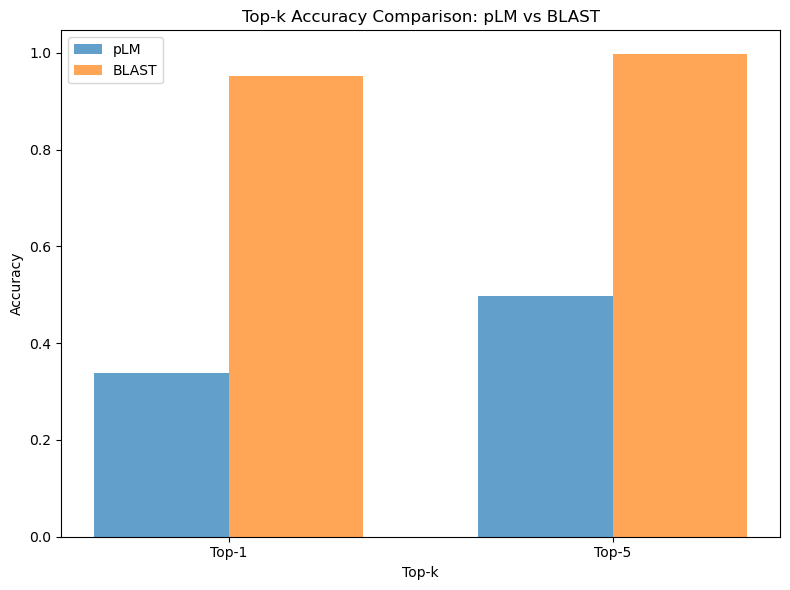

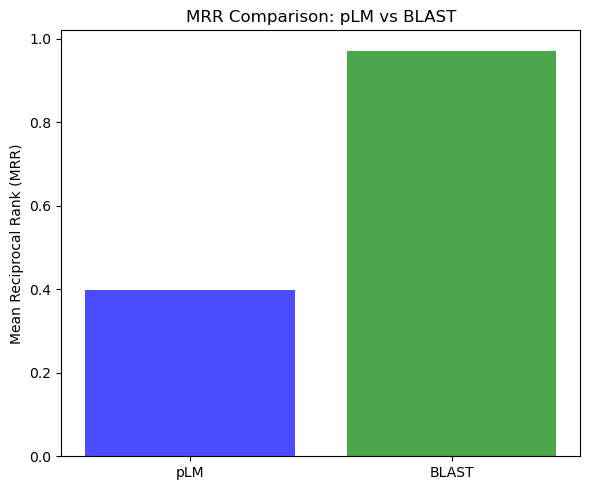

In [ ]:
topk_accuracies_plm = [0.3388, 0.4970]
topk_accuracies_blast = [0.9516, 0.9965]
mrr_plm = mrr_plm
mrr_blast = mrr_blast

plt.figure(figsize=(8, 6))

x_labels = ['Top-1', 'Top-5']
bar_width = 0.35
index = range(len(x_labels))

plt.bar(index, topk_accuracies_plm, bar_width, label='pLM', alpha=0.7)
plt.bar([i + bar_width for i in index], topk_accuracies_blast, bar_width, label='BLAST', alpha=0.7)

plt.xlabel('Top-k')
plt.ylabel('Accuracy')
plt.title('Top-k Accuracy Comparison: pLM vs BLAST')
plt.xticks([i + bar_width / 2 for i in index], x_labels)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))

plt.bar(['pLM', 'BLAST'], [mrr_plm, mrr_blast], color=['blue', 'green'], alpha=0.7)

plt.ylabel('Mean Reciprocal Rank (MRR)')
plt.title('MRR Comparison: pLM vs BLAST')
plt.tight_layout()
plt.show()
